In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import re
from dotenv import load_dotenv
import os
import requests
pd.set_option('display.max_columns', 200)

In [2]:
#load-in data

In [3]:
#this function loads in all of the data and creates a dataframe for each file, then merges all into 
#one large dataset and cleans the data
def loadData(directory):
    
    directory_path = directory

    json_data_list = []

    # Iterate through each file in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.json'):
            file_path = os.path.join(directory_path, filename)

            # Open the file and load the JSON data
            with open(file_path, 'r') as file:
                json_data = json.load(file)

                # Append the JSON data to the list
                json_data_list.append(json_data)
    #Concatenating dataframes into one big one
    merged_spotify_data_frames = []
    for dataset in json_data_list:
        df = pd.DataFrame(dataset)
        merged_spotify_data_frames.append(df)
    merged_df = pd.concat(merged_spotify_data_frames)
    #Cleaning the data
    merged_df["ts"] = pd.to_datetime(merged_df["ts"])
    merged_df = merged_df.rename(columns = {"ts":"date","master_metadata_track_name":"track_name","master_metadata_album_artist_name":"artist_name","master_metadata_album_album_name":"album_name"})
    merged_df = merged_df.drop(columns = ["ip_addr_decrypted","user_agent_decrypted","episode_name","spotify_episode_uri","offline_timestamp","incognito_mode","episode_show_name","skipped"])
    merged_df["date"] = merged_df["date"].astype(str)
    merged_df["date"] = merged_df["date"].apply(lambda x: x[0:10])
    merged_df["date"] = pd.to_datetime(merged_df["date"])
    merged_df = merged_df[merged_df["ms_played"] > 10000]
    merged_df["spotify_track_uri"] = merged_df["spotify_track_uri"].astype(str)
    merged_df["spotify_track_uri"] = merged_df["spotify_track_uri"].apply(lambda x: x[14:])
    

    return merged_df

In [4]:
#put your directory where your spotify data files are stored in here
all_data_df = loadData("/Users/jordankesner/Desktop/Coding/INFO 3510 Music as Info/Spotify Data Analysis")

In [5]:
all_data_df.head()

,date,username,platform,ms_played,conn_country,track_name,artist_name,album_name,spotify_track_uri,reason_start,reason_end,shuffle,offline
0,2022-01-30,jordan.kesner,"iOS 15.2.1 (iPhone13,4)",197142,US,Rip Stick (feat. Pooh Shiesty & Sykobob),Kodak Black,Rip Stick (feat. Pooh Shiesty & Sykobob),6f4WfdafzQW0189yvQAJxZ,fwdbtn,trackdone,True,False
1,2022-01-30,jordan.kesner,"iOS 15.2.1 (iPhone13,4)",128156,US,My Shit,A Boogie Wit da Hoodie,Artist,5uQOauh47VFt3B2kV9kRXw,trackdone,trackdone,True,False
2,2022-01-30,jordan.kesner,"iOS 15.2.1 (iPhone13,4)",87642,US,On Me,Lil Baby,On Me,4Iedi94TIaB2GGb1nMB68v,trackdone,fwdbtn,True,False
3,2022-01-30,jordan.kesner,"iOS 15.2.1 (iPhone13,4)",221746,US,The Way Life Goes (feat. Oh Wonder),Lil Uzi Vert,Luv Is Rage 2,2eAZfqOm4EnOF9VvN50Tyc,fwdbtn,trackdone,True,False
4,2022-01-31,jordan.kesner,"iOS 15.2.1 (iPhone13,4)",55371,US,Down Below,Roddy Ricch,Feed Tha Streets II,4SWWe2OYC4mqf40Gc2RSdl,trackdone,endplay,True,False


In [6]:
len(all_data_df)

71645

In [7]:
load_dotenv("3510-Copy1.env")

True

In [8]:
clientID = os.getenv("SPOTIFY_CLIENT_ID")
clientSecret = os.getenv("SPOTIFY_CLIENT_SECRET")
grantType = "client_credentials"
bodyParams = {"grant_type":grantType}
url = "https://accounts.spotify.com/api/token/"
response = requests.post(url, data=bodyParams, auth = (clientID, clientSecret)).json()

In [9]:
headers = {"Authorization":"Bearer "+response["access_token"]} 

rootURL = "https://api.spotify.com/v1/"

In [12]:
def analyzeMonth(month, year, df):
    #get month dataframe
    month_df = df.loc[(df["date"].dt.year == year) & (df["date"].dt.month == month)]
    if(month_df.empty):
        print("You do not have data for this month and year.")
    else:
        #gets and reports the minutes of music listened to this month
        total_listening_time_ms = month_df["ms_played"].sum()
        total_listening_time_seconds = total_listening_time_ms // 1000
        total_listening_time_minutes = total_listening_time_seconds // 60
        print(f"You have listened to {total_listening_time_minutes} minutes of music this month.")
        #calculates how many more or less minutes listened to 
        if(month == 1):
            year_before = year-1
            month_before_df = df.loc[(df["date"].dt.year == year_before) & (df["date"].dt.month == 12)]
        else:
            month_before_df = df.loc[(df["date"].dt.year == year) & (df["date"].dt.month == month-1)]

        last_month_listening_time_ms = month_before_df["ms_played"].sum()
        last_month_seconds = last_month_listening_time_ms // 1000
        last_month_minutes = last_month_seconds // 60
        if(last_month_minutes < total_listening_time_minutes):
            change_in_listening = total_listening_time_minutes - last_month_minutes
            print(f"You have listened to {change_in_listening} more minutes of music than last month.")
        elif(last_month_minutes > total_listening_time_minutes):
            change_in_listening = last_month_minutes - total_listening_time_minutes
            print(f"You have listened to {change_in_listening} less minutes of music than last month.")
        
        #gets day with most music listened to 
        top_day = month_df["date"].dt.date.value_counts()[0:1]
        date = ""
        songs_of_the_day = ""
        for key in top_day.keys():
            date = key
            songs_of_the_day = top_day[key]
        formatted_date = date.strftime('%B %d, %Y')
        print(f"The day you listened to the most music this month was {formatted_date} and you listened to {songs_of_the_day} songs.")
        


        #Gets top ten artists and songs for each month
        top_artists = month_df["artist_name"].value_counts(ascending=False)[0:10]
        top_songs = month_df["track_name"].value_counts(ascending=False)[0:10]

        artists = []
        num_of_songs = []
        for key in top_artists.keys():
            artist = key.replace('$','S')
            artists.append(artist)
            num_of_songs.append(top_artists[key])

        song_names = []
        num_of_listens = []
        for key in top_songs.keys():
            song = key.replace('$','S')
            song_names.append(song)
            num_of_listens.append(top_songs[key])
        song_names_without_features = []
        for song in song_names:
            song = re.sub(r'\(.*\)', '', song)
            song_names_without_features.append(song)
        #Gets top 20 artists and values to use for genres
        top_artists_values = month_df["artist_name"].value_counts()[:20].tolist()
        top_artists_names = month_df["artist_name"].value_counts().keys()[:20].tolist()
        artistIds = []
        #Make requests for artists' ids
        for artist in top_artists_names:
            artistReq = requests.get(rootURL+"search?q="+ artist + "&type=artist",headers=headers).json()
            artistId = artistReq["artists"]["items"][0]["id"]
            artistIds.append(artistId)
        #make requests for artists' genres
        genres = []
        for artist_id in artistIds:
            req = requests.get(rootURL + "artists/"+ artist_id, headers=headers).json()
            genres.append(req["genres"])
        cleaned_genres = []
        for genre_list in genres:
            if any("rock" in s for s in genre_list):
                cleaned_genres.append("rock")
            elif any("rap" in s for s in genre_list):
                cleaned_genres.append("rap")
            elif(len(genre_list) > 0):
                cleaned_genres.append(genre_list[0])
        genre_counts = {}
        for i in range(len(cleaned_genres)):
            genre = cleaned_genres[i]
            value = top_artists_values[i]
            if genre in genre_counts:
                genre_counts[genre] += value
            else:
                genre_counts[genre] = value
        genre_df = pd.DataFrame(list(genre_counts.items()), columns=['Genre', 'Count'])
        
        

        #plot top artists
        plt.barh(artists,num_of_songs)
        plt.title(f'Top Artists of {calendar.month_name[month]}, {year}')
        plt.xlabel('Number of Songs Listened To')
        plt.ylabel('Artists')
        plt.show()    
        #plot top songs 
        plt.barh(song_names_without_features,num_of_listens)
        plt.title(f'Top Songs of {calendar.month_name[month]}, {year}')
        plt.xlabel('Number of Times Listened To')
        plt.ylabel('Songs')
        plt.show()
        #plot top genres
        genre_plot_list = genre_df["Genre"]
        genre_plot_counts = genre_df["Count"]
        plt.barh(genre_plot_list, genre_plot_counts)
        plt.title(f'Top Genres of {calendar.month_name[month]}, {year}')
        plt.xlabel('Number of Times Listened To')
        plt.ylabel('Genre')
        plt.show()
        

You have listened to 3459 minutes of music this month.
You have listened to 186 more minutes of music than last month.
The day you listened to the most music this month was April 17, 2019 and you listened to 142 songs.


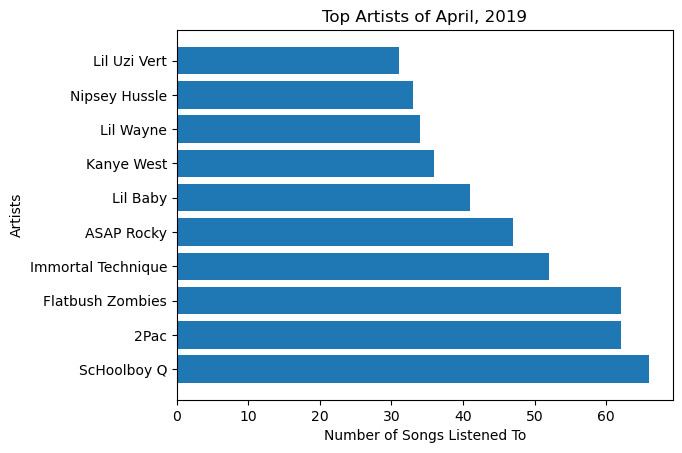

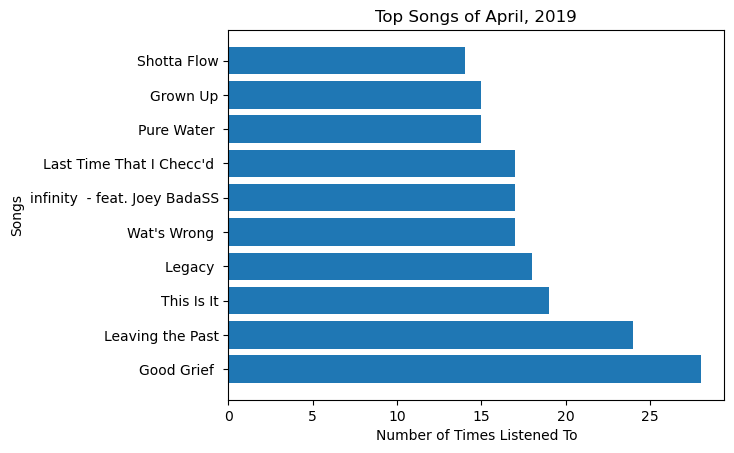

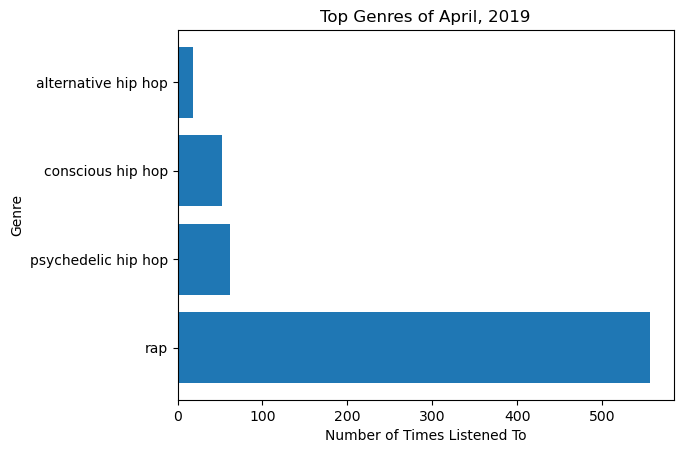

In [13]:
analyzeMonth(4, 2019, all_data_df)

In [250]:
def yearInReview(year, df):
    year_df = df.loc[df["date"].dt.year == year]
    months_list = [
    "January", "February", "March", "April", 
    "May", "June", "July", "August", 
    "September", "October", "November", "December"
    ]
    month_frames = []
    for i in range(1,13):
        month_df = year_df.loc[year_df["date"].dt.month == i]
        month_frames.append(month_df)
    months_listening_time = []
    for month in month_frames:
        total_listening_time_ms = month["ms_played"].sum()
        total_listening_time_seconds = total_listening_time_ms // 1000
        total_listening_time_minutes = total_listening_time_seconds // 60
        months_listening_time.append(total_listening_time_minutes)
        
    top_songs = year_df["track_name"].value_counts(ascending=False)[0:10]


    song_names = []
    num_of_listens = []
    for key in top_songs.keys():
        song_names.append(key)
        num_of_listens.append(top_songs[key])
    song_names_without_features = []
    for song in song_names:
        song = re.sub(r'\(.*\)', '', song)
        song_names_without_features.append(song)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))  # 1 row, 2 columns for subplots, figsize for overall figure size

    
    ax1.plot(months_list,months_listening_time)
    ax1.set_xlabel('Months')
    ax1.set_xticklabels(months_list,rotation=45)
    ax1.set_ylabel('Listening Time (In Minutes)')
    ax1.set_title(f'Listening Time Throughout {year}')
    
    #plot top songs 
    ax2.barh(song_names_without_features,num_of_listens)
    ax2.set_title(f'Top Songs of {year}')
    ax2.set_xlabel('Number of Times Listened To')
    ax2.set_ylabel('Songs')
    plt.tight_layout()  
    plt.show()




/var/folders/lt/v7f4g3910flfhby34v4b7n7w0000gn/T/ipykernel_95067/1266200483.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(months_list,rotation=45)


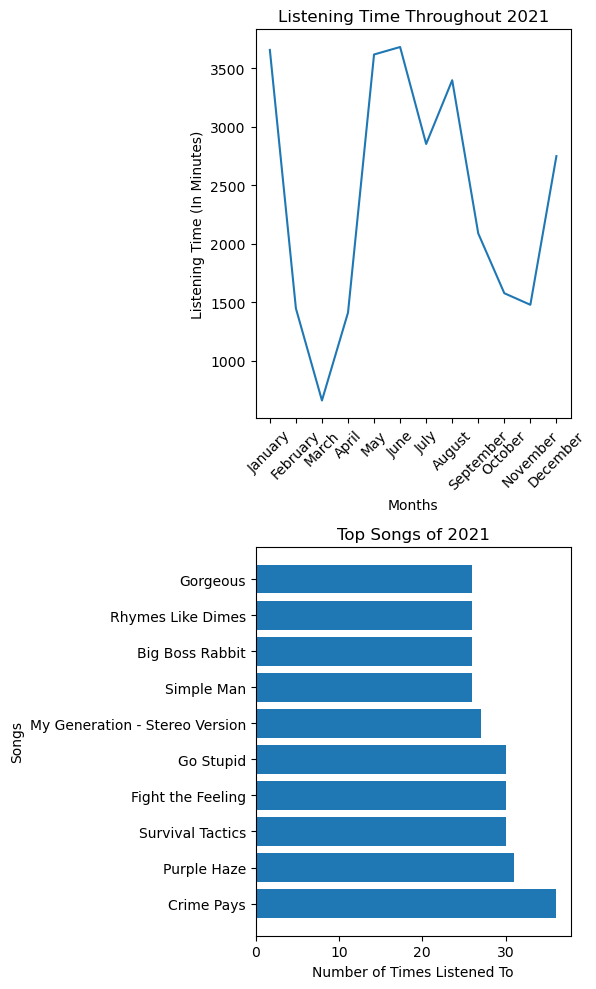

In [251]:
yearInReview(2021, all_data_df)